In [1]:
!date

Sat Feb 22 14:38:27 PST 2020


# Merfish

In [24]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from scipy.spatial import ConvexHull
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
clusters = pd.read_csv("../merfish/cell_labels.csv")
clusters.index = clusters["Unnamed: 0"].values
del clusters["Unnamed: 0"]

In [3]:
adata = anndata.read_h5ad("../merfish/merfish_M1.h5ad")
tmp = pd.DataFrame({col: adata.obs.index.map(clusters[col]) for col in clusters})
adata.obs = tmp
mtx = adata.X
adata.layers["log1p"] = np.log1p((mtx/mtx.sum(axis=1)[:,None])*1000000)

In [4]:
adata.layers["X"] = mtx
adata.X = csr_matrix(adata.layers["log1p"])

In [5]:
scanp.pp.scale(adata, max_value=10)

In [6]:
adata.obs.head()

label     subclass          sampleID            sliceID label_v1  \
0      Sst_1          Sst  dataset2_sample6  dataset2_slice109      I30   
1       Endo  Endothelial  dataset1_sample1   dataset1_slice50     Endo   
2    L6_IT_1        L6_IT  dataset2_sample3  dataset2_slice139       E8   
3  L2/3_IT_3      L2/3_IT  dataset2_sample1   dataset2_slice61       E2   
4       VLMC         VLMC  dataset1_sample5  dataset1_slice260     VLMC   

   AP_distance (um)   pos_x (um)   pos_y (um)  
0              1180   -79.474594  2211.467867  
1               490  3837.284502 -3847.753461  
2              1480  3502.243851 -3511.940334  
3               700 -3975.718063 -2609.660891  
4              2590 -6370.114257   623.408623

In [7]:
sliceID = adata.obs.sliceID.unique()

In [8]:
gb = adata.obs.groupby("sliceID")["pos_x (um)", "pos_y (um)"]

In [9]:
adata.shape

(243799, 254)

In [10]:
cols = ["transcript_id", "gene_id", "gene_name", "transcript_name", "chromosome", "start", "stop", "strand"]
t2g = pd.read_csv("/home/sina/projects/mop/reference/cellranger_index/refdata-cellranger-mm10-3.0.0/kb_out/t2g.txt", sep="\t", header=None, names=cols)

In [11]:
c = t2g.groupby("gene_name")["transcript_id"].nunique()

In [12]:
adata.var["n_iso"] = adata.var.index.map(c)

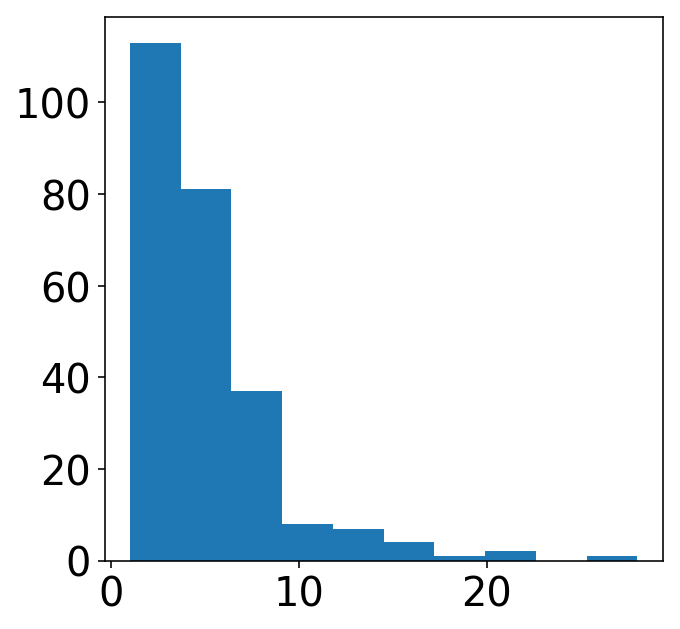

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
x = adata.var["n_iso"].values
ax.hist(x)

plt.show()

In [14]:
gene = "Pvalb"

In [15]:
gene in adata.var.index.values

True

In [16]:
def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

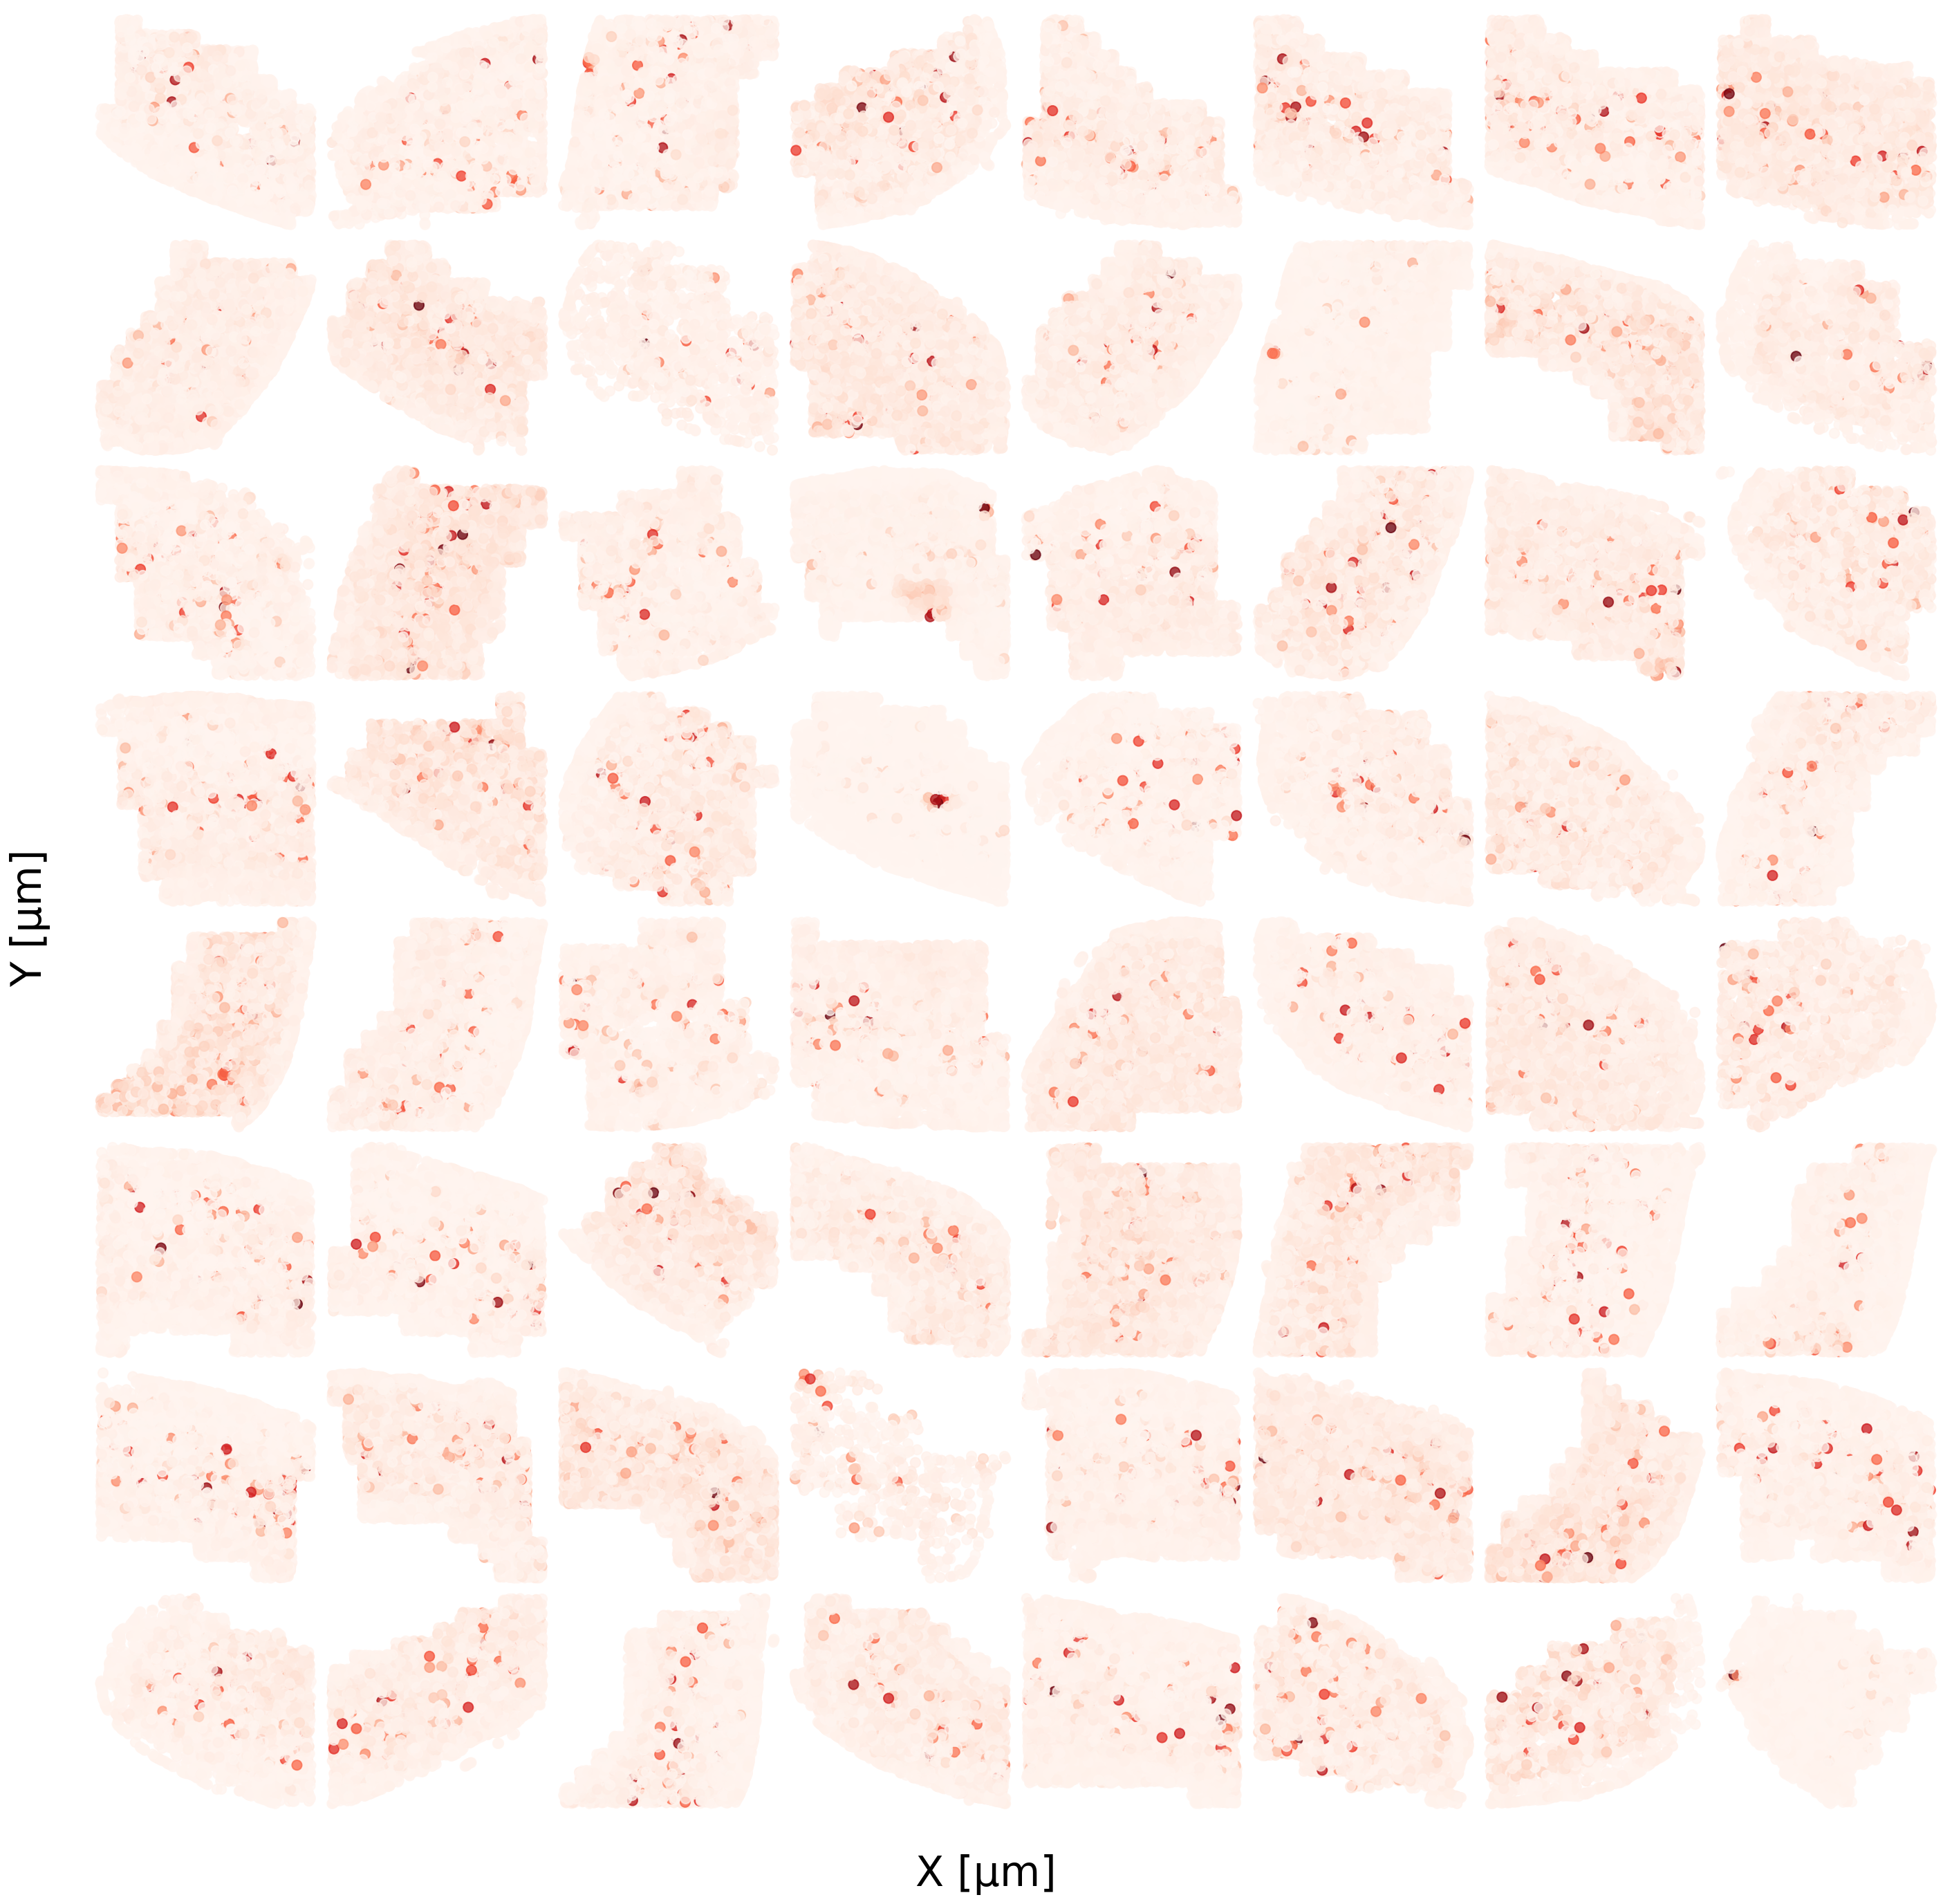

CPU times: user 1min 15s, sys: 4.22 s, total: 1min 19s
Wall time: 1min 12s


In [114]:
%%time
fig, ax = plt.subplots(figsize=(24,24), ncols=8, nrows=8)
fig.subplots_adjust(hspace=0, wspace=0)
axs = trim_axs(ax, len(sliceID))

gene_vec = adata.layers["X"][:,adata.var.index == gene]


for sidx, (ax, slice_name) in enumerate(zip(axs, sliceID)):

    s = gb.get_group(sliceID[sidx])
    
    X_mask = s.index.values
    
    x = adata.obs["pos_x (um)"][X_mask]
    y = adata.obs["pos_y (um)"][X_mask]
    
    # points = np.array([x.tolist(), y.tolist()]).T
    # hull = ConvexHull(points)
    
    c = np.asarray(gene_vec[X_mask]).reshape(-1)
    
    ax.scatter(x, y, c=c, cmap="Reds", label=slice_name, s=50, alpha=0.75)
    
    # x = points[hull.vertices,0].tolist() + [points[hull.vertices,0].tolist()[0]]
    # y = points[hull.vertices,1].tolist() + [points[hull.vertices,1].tolist()[0]]
    # ax.plot(x, y, color="grey")
    ax.set_xlabel("X [µm]")
    ax.set_ylabel("y [µm]")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()

fig.text(0.5, 0.1, 'X [µm]', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'Y [µm]', ha='center', va='center', rotation='vertical', fontsize=30)
plt.savefig("./level_2_fig/merfish_{}.png".format(gene), bbox_inches='tight',dpi=300)
plt.show()

In [23]:
specific_cluster = "Pvalb"

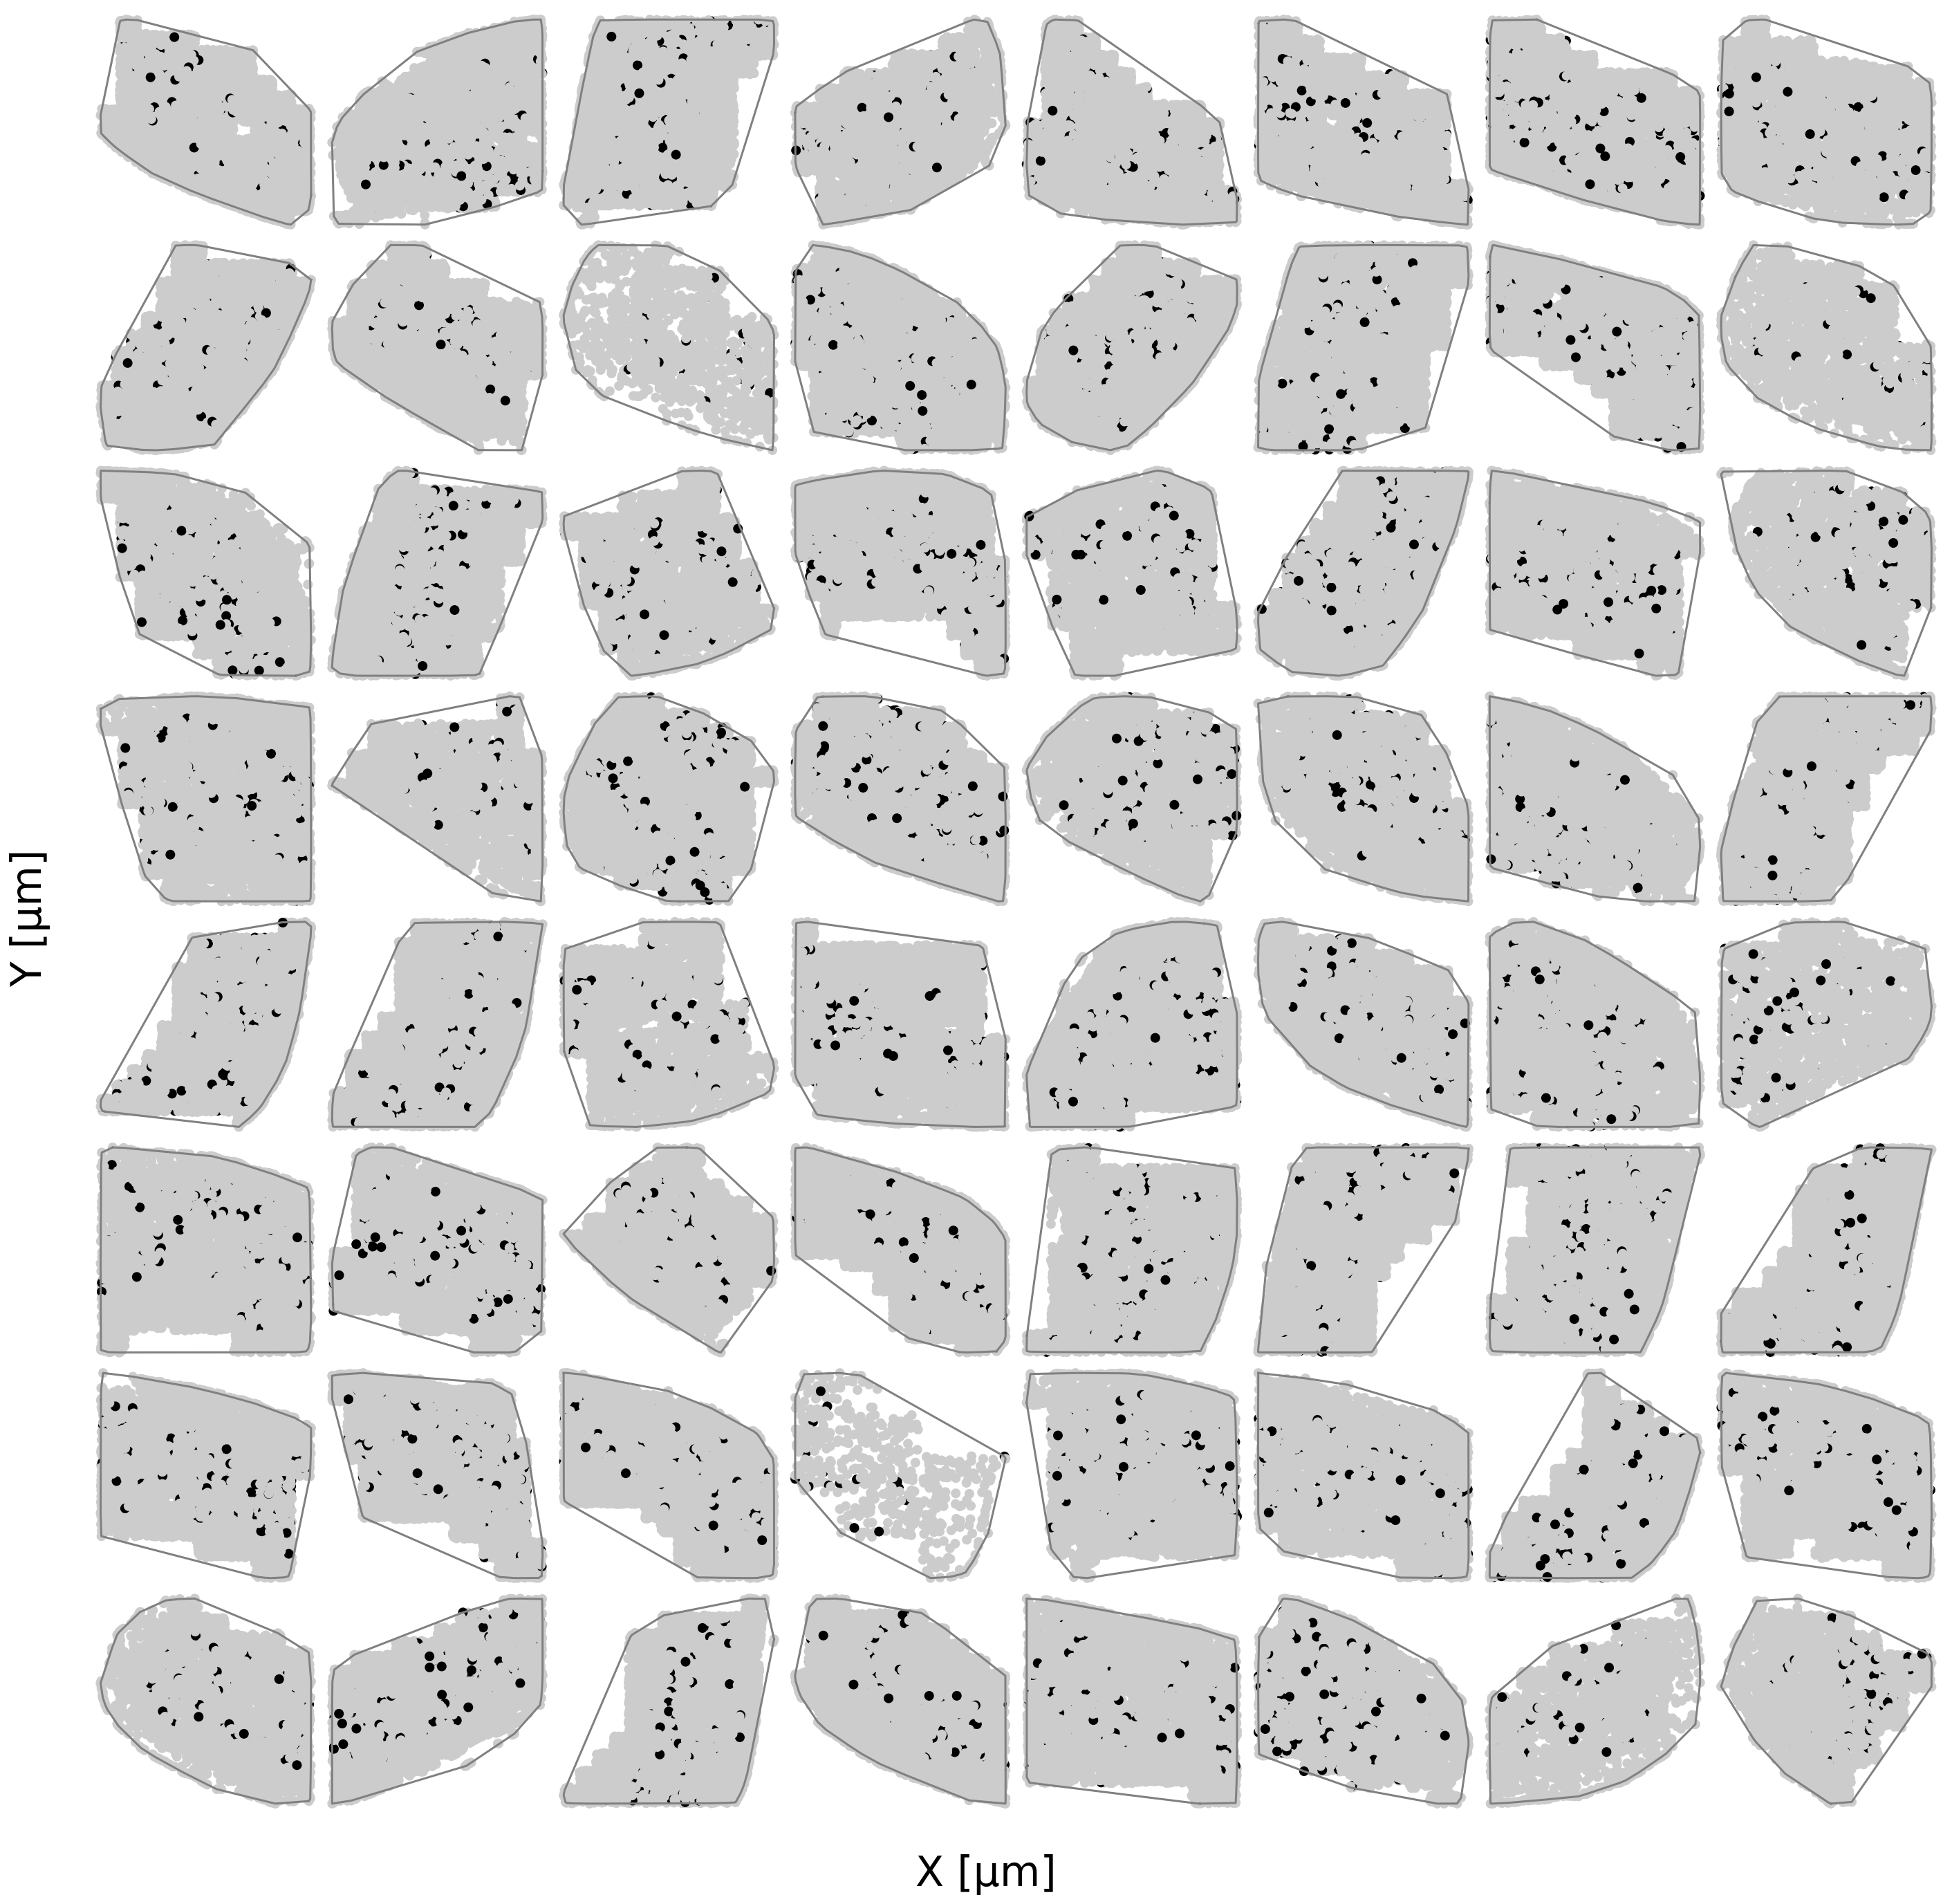

CPU times: user 21.2 s, sys: 2.67 s, total: 23.9 s
Wall time: 18.7 s


In [25]:
%%time
fig, ax = plt.subplots(figsize=(24,24), ncols=8, nrows=8)
fig.subplots_adjust(hspace=0, wspace=0)

axs = trim_axs(ax, len(sliceID))

#gene_vec = adata.X[:,adata.var.index == gene]
le = LabelEncoder()
subclass_vec = le.fit_transform(adata.obs.subclass.values==specific_cluster)

for sidx, (ax, slice_name) in enumerate(zip(axs, sliceID)):
    s = gb.get_group(sliceID[sidx])
    
    X_mask = s.index.values
    
    x = adata.obs["pos_x (um)"][X_mask]
    y = adata.obs["pos_y (um)"][X_mask]
    c = np.asarray(subclass_vec[X_mask]).reshape(-1)
    
    points = np.array([x.tolist(), y.tolist()]).T
    hull = ConvexHull(points)
    
    ax.scatter(x, y, c=c, cmap="nipy_spectral_r", label=slice_name)

    x = points[hull.vertices,0].tolist() + [points[hull.vertices,0].tolist()[0]]
    y = points[hull.vertices,1].tolist() + [points[hull.vertices,1].tolist()[0]]
    ax.plot(x, y, color="grey")
    
    
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_axis_off()
    
fig.text(0.5, 0.1, 'X [µm]', ha='center', va='center', fontsize=30)
fig.text(0.1, 0.5, 'Y [µm]', ha='center', va='center', rotation='vertical', fontsize=30)
#plt.savefig("./level_2_fig/merfish_{}_{}.png".format(gene, specific_cluster), bbox_inches='tight',dpi=300)
plt.show()

In [26]:
unique = adata.obs.subclass.unique()

In [27]:
unique

array(['Sst', 'Endothelial', 'L6_IT', 'L2/3_IT', 'VLMC', 'L6_CT',
       'L4/5_IT', 'Vip', 'Pvalb', 'Oligodendrocytes', 'Microglia',
       'L5_PT', 'L5_IT', 'Pericytes', 'Astrocytes', 'L56_NP',
       'L6_IT_Car3', 'OPC', 'Lamp5', 'SMC', 'Sncg', 'striatum', 'L6b',
       'Macrophages', 'Sst_Chodl', 'Ependymal'], dtype=object)

In [28]:
specific_gene = "Pvalb"
specific_cluster = "Pvalb"

In [29]:
adata.obs.subclass.unique()

array(['Sst', 'Endothelial', 'L6_IT', 'L2/3_IT', 'VLMC', 'L6_CT',
       'L4/5_IT', 'Vip', 'Pvalb', 'Oligodendrocytes', 'Microglia',
       'L5_PT', 'L5_IT', 'Pericytes', 'Astrocytes', 'L56_NP',
       'L6_IT_Car3', 'OPC', 'Lamp5', 'SMC', 'Sncg', 'striatum', 'L6b',
       'Macrophages', 'Sst_Chodl', 'Ependymal'], dtype=object)

In [104]:
unique_map = {
"L5_IT" : "L5 IT",
"L6_CT" : "L6 CT",
"L6b" : "L6b",
"Vip" : "Vip",
"Pvalb" : "Pvalb",
"L2/3_IT" : "L2/3 IT",
"L6_IT" : "L6 IT",
"Sst" : "Sst",
"Lamp5" : "Lamp5",
"L56_NP" : "L5/6 NP",
"Sncg" : "Sncg",
"SMC" : "SMC",
"L5_PT" : "L5 ET", # Check
"Endothelial" : "Endo",
"Astrocytes" : "Astro",
"VLMC" : "VLMC",
"L6_IT_Car3" : "L6 IT Car3"}

inv_map = {v: k for k, v in unique_map.items()}

In [31]:
specific_gene

'Pvalb'

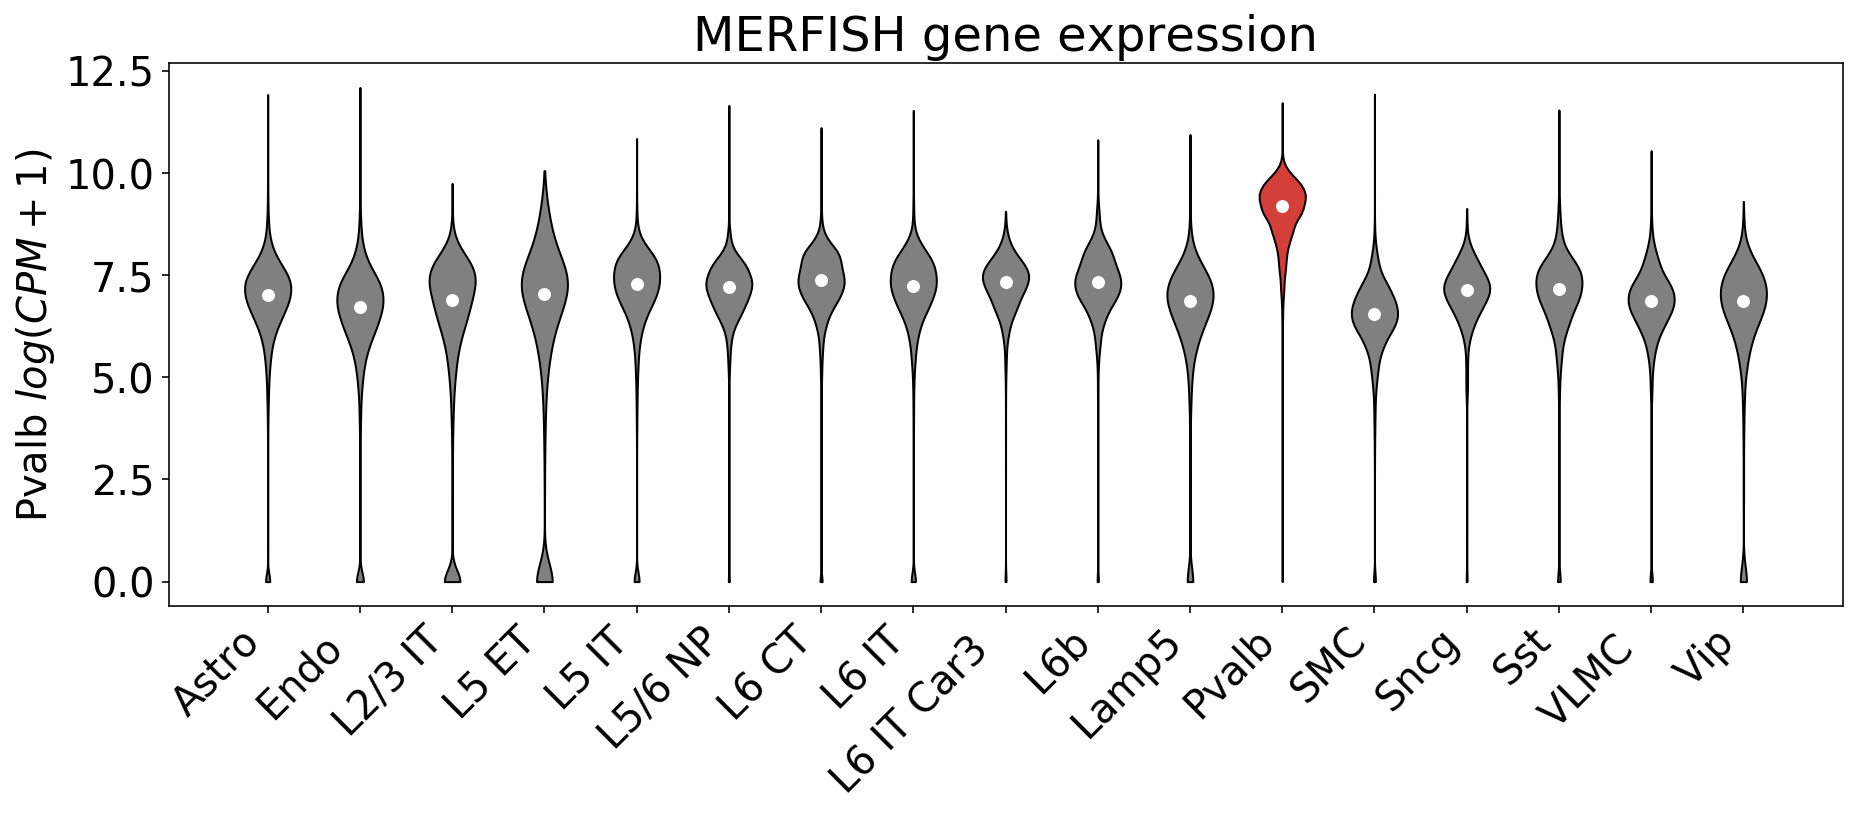

In [33]:
fig, ax = plt.subplots(figsize=(15,5), nrows=1)



unique = np.unique(adata.obs.subclass)
labels = [unique_map.get(i) for i in unique_map.keys()]
labels = np.sort(labels).tolist()
lidx = np.arange(1, len(labels)+1)  # the label locations

tmp_specific_cluster = unique_map[specific_cluster]

midx = labels.index(tmp_specific_cluster)


tmp = adata[:,adata.var.index.values==specific_gene]

x = []
for c in labels:
    tmp_cluster = inv_map[c]
    x.append(np.asarray(tmp[adata.obs.subclass==tmp_cluster].layers["log1p"]).reshape(-1).tolist())

parts = ax.violinplot(x, showmedians=False, showextrema=False)
for pcidx, pc in enumerate(parts['bodies']):
    pc.set_facecolor('grey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    if pcidx == midx:
        pc.set_facecolor('#D43F3A')

medians = [np.median(i) for i in x]
ax.scatter(lidx, medians, marker='o', color='white', s=30, zorder=3)
ax.set_xticks(lidx)
ax.set_xticklabels(labels, rotation=45, ha="right")
#ax.axhline(y=medians[midx], color="k")
ax.set_ylabel("{} $log(CPM + 1)$".format(specific_gene))
ax.set_title("MERFISH gene expression")
plt.savefig("./level_2_fig/merfish_smartseq_mfviolin_{}.png".format(specific_gene), bbox_inches='tight',dpi=300)
plt.show()

# Cluster comparisons

In [35]:
adata.obs["cell_id"] = adata.obs.index.values

In [36]:
ssgene = anndata.read_h5ad("cell_ranger_annotation/gene.h5ad")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [38]:
print(ssgene)
print(adata)

AnnData object with n_obs × n_vars = 6043 × 20586 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'
AnnData object with n_obs × n_vars = 243799 × 254 
    obs: 'label', 'subclass', 'sampleID', 'sliceID', 'label_v1', 'AP_distance (um)', 'pos_x (um)', 'pos_y (um)', 'cell_id'
    var: 'n_iso'
    layers: 'log1p', 'X'


In [41]:
mfish = adata[:,~adata.var.index.duplicated()]
ssgene = ssgene[:,~ssgene.var["gene_name"].duplicated()]

In [42]:
common_genes = np.intersect1d(ssgene.var.gene_name.values, mfish.var.index.values)

In [43]:
mfish = mfish[:,mfish.var.index.isin(common_genes)]
ss = ssgene[:,ssgene.var.gene_name.isin(common_genes)]

In [45]:
print(ss)
print(mfish)

View of AnnData object with n_obs × n_vars = 6043 × 247 
    obs: 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'cluster_color', 'size', 'cell_id', 'subclass_id', 'class_id', 'cell_TPM', 'percent_mito', 'n_genes', 'pass_count_filter', 'leiden', 'louvain'
    var: 'transcript_id', 'gene_id', 'gene_name', 'transcript_name', 'txn_list', 'num_isoforms', 'gene_TPM', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'leiden', 'louvain', 'neighbors'
    obsm: 'X_nca', 'X_nca_tsne', 'X_pca', 'X_pca_tsne'
    layers: 'X', 'log1p'
View of AnnData object with n_obs × n_vars = 243799 × 247 
    obs: 'label', 'subclass', 'sampleID', 'sliceID', 'label_v1', 'AP_distance (um)', 'pos_x (um)', 'pos_y (um)', 'cell_id'
    var: 'n_iso'
    layers: 'log1p', 'X'


In [46]:
def group_mtx_by_cluster(mtx, components, features, s2t, source_id="transcript_id", target_id="gene_id", by="features"):
    """
    mtx: ndarray components by features 
    components: labels for rows of mtx
    features: labels for columns of mtx
    s2t: pandas dataframe mapping source (features or components) to a
    targets features(components) to group by
    target_id: column name in s2t to group by
    """
    if target_id not in s2t.columns: return -1
    
    ncomp   = components.shape[0]
    nfeat   = features.shape[0]
    ntarget = s2t[target_id].nunique()
    
    if by =="features": 
        source = features
    elif by =="components": 
        source = components
    
    # Map the source to an index
    source2idx = dict(zip(source, range(len(source))))
    # Map the target to a list of source indices
    target2idx = (s2t.groupby(target_id)[source_id].apply(lambda x: [source2idx[i] for i in x])).to_dict()
    
    # array of unique targets
    unique = s2t[target_id].unique().astype(str)
    nuniq = unique.shape[0]
    X = np.zeros((nuniq, mtx.shape[1]))
    
    for tidx, t in enumerate(unique):
        # Grab the matrix indices corresponding to columns and source columns to group by
        source_indices = target2idx[t]
        #print(source_indices)
        
        # breaks generality
        sub_mtx = mtx[source_indices,:].mean(axis=0) # Sum on source indicies
        X[tidx,:] = sub_mtx # place summed vector in new matrix
        
    # Return matrix that is grouped by
    return (X, components, unique)

In [73]:
ss = ss[ss.obs.subclass_label!="Low Quality"]

In [74]:
%%time

mtx        = ss.X
components = ss.obs.cell_id.values
assignments   = ss.obs.cell_id.values

source_id = "transcript_id"
target_id = "gene_id"


s2t = ss.obs

# Data for gene matrix
X1, c1, f1 = group_mtx_by_cluster(mtx, components, assignments, s2t, source_id="cell_id", target_id="subclass_label")

CPU times: user 33.3 ms, sys: 6.84 ms, total: 40.1 ms
Wall time: 38.8 ms


In [52]:
unique_map

{'L5_IT': 'L5 IT',
 'L6_CT': 'L6 CT',
 'L6b': 'L6b',
 'Vip': 'Vip',
 'Pvalb': 'Pvalb',
 'L2/3_IT': 'L2/3 IT',
 'L6_IT': 'L6 IT',
 'Sst': 'Sst',
 'Lamp5': 'Lamp5',
 'L56_NP': 'L5/6 NP',
 'Sncg': 'Sncg',
 'SMC': 'SMC',
 'L5_PT': 'L5 ET',
 'Endothelial': 'Endo ',
 'Astrocytes': 'Astro',
 'VLMC': 'VLMC ',
 'L6_IT_Car3': 'L6 IT Car3 '}

In [105]:
mfish.obs["ss_subclass"] = mfish.obs["subclass"].apply(lambda x: unique_map.get(x, "None"))

Trying to set attribute `.obs` of view, copying.


In [106]:
mfish.obs.head()

label     subclass          sampleID            sliceID label_v1  \
0      Sst_1          Sst  dataset2_sample6  dataset2_slice109      I30   
1       Endo  Endothelial  dataset1_sample1   dataset1_slice50     Endo   
2    L6_IT_1        L6_IT  dataset2_sample3  dataset2_slice139       E8   
3  L2/3_IT_3      L2/3_IT  dataset2_sample1   dataset2_slice61       E2   
4       VLMC         VLMC  dataset1_sample5  dataset1_slice260     VLMC   

   AP_distance (um)   pos_x (um)   pos_y (um)  cell_id ss_subclass  
0              1180   -79.474594  2211.467867        0         Sst  
1               490  3837.284502 -3847.753461        1        Endo  
2              1480  3502.243851 -3511.940334        2       L6 IT  
3               700 -3975.718063 -2609.660891        3     L2/3 IT  
4              2590 -6370.114257   623.408623        4        VLMC

In [107]:
mfish = mfish[mfish.obs.ss_subclass != "None"]

In [108]:
%%time

mtx           = mfish.X
components    = mfish.obs.cell_id.values
assignments   = mfish.obs.cell_id.values


s2t = mfish.obs

# Data for gene matrix
X2, c2, f2 = group_mtx_by_cluster(mtx, components, assignments, s2t, source_id="cell_id", target_id="ss_subclass")

CPU times: user 260 ms, sys: 10.3 ms, total: 271 ms
Wall time: 269 ms


In [109]:
from scipy import stats

In [110]:
%%time
r2 = []
for cidx, c in enumerate(f1):
    c1idx = np.where(f1==c)[0][0]
    c2idx = np.where(f2==c)[0][0]
    
    
    x = X1[c1idx]
    y = X2[c2idx]
    r, p = stats.pearsonr(x, y)
    r2.append(r**2)

CPU times: user 2.18 ms, sys: 3.23 ms, total: 5.41 ms
Wall time: 5.01 ms


In [111]:
r2

[0.00018550661428193375,
 0.004324144210553815,
 0.005171035739878995,
 0.00097510775742272,
 0.0013610052146682964,
 0.0015415078229502025,
 0.00884377635570409,
 0.00011927105790215862,
 0.0007793349992843173,
 0.014401972495415893,
 0.019013171302339878,
 0.007850322204682432,
 0.002143144604793155,
 0.0035084416712949907,
 0.0007000041312314447,
 0.0007036474103044514,
 0.00012612642725301894]

In [112]:
X2

array([[-0.06907269, -0.055862  , -0.03211818, ..., -0.71062273,
        -1.10906661,  1.36047828],
       [-0.11067701, -0.22249825, -0.14255054, ..., -0.71968722,
        -0.37996376,  0.21477546],
       [ 0.0322429 ,  0.12885039,  0.07275672, ...,  0.99439394,
         0.57433271, -0.39102158],
       ...,
       [-0.0613278 , -0.16572092, -0.08917412, ..., -1.43079221,
        -0.59756702, -0.15362035],
       [-0.02856106, -0.04928989,  0.03536552, ..., -0.82851946,
        -1.02054667,  1.47764695],
       [-0.0451743 ,  0.06052591,  0.10666722, ...,  1.06118822,
         0.56145585, -0.4195081 ]])

In [83]:
f1

array(['Vip', 'L5 IT', 'Lamp5', 'Sst', 'L5/6 NP', 'Pvalb', 'L2/3 IT',
       'L6 IT', 'L6 CT', 'L6b', 'L5 ET', 'Sncg', 'L6 IT Car3', 'SMC',
       'VLMC', 'Astro', 'Endo'], dtype='<U10')

In [85]:
f2

array(['Sst', 'Endo ', 'L6 IT', 'L2/3 IT', 'VLMC ', 'L6 CT', 'Vip',
       'Pvalb', 'L5 ET', 'L5 IT', 'Astro', 'L5/6 NP', 'L6 IT Car3 ',
       'Lamp5', 'SMC', 'Sncg', 'L6b'], dtype='<U11')

In [103]:
c

'Endo'

In [87]:
np.where(f2==c)[0]

array([], dtype=int64)

In [262]:
ss_size = ss.obs["subclass_label"].value_counts()[f1]